In [4]:
# import sklearn
# import xgboost

# # To use gridsearch from sklearn for XGBoost, Scikit-learn versino should be lower than 1.6.0
# print(f"Scikit-learn version: {sklearn.__version__}")
# print(f"XGBoost version: {xgboost.__version__}")

# type(sklearn.__version__)
# try:
#   if sklearn.__version__ >= "1.6.0":
#     raise Exception("sklearn version should be lower than 1.6.0 but got sklearn version higher than b1.6.0. Run the code below and restart the current session")
# except Exception as e:
#   print(e)

In [5]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.5.2

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

# data_dir = '/content/drive/MyDrive/csv_output_with_phases'

In [8]:
data_dir = '../csv_output_with_phases'  # Replace with your directory

In [9]:
# data head 보여주기
# data column 설명 추가
# magnitude 왜 했는지 설명

import os
import pandas as pd
import numpy as np

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)

            df = pd.read_csv(filepath)

            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot
            df['time'] = pd.to_datetime(df['time'])
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y',
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase']
            df = df[cols]
            # df = df[df['phase'] != 0]
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

data = load_data_from_files(data_dir)

In [10]:
data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase
0,vh92aaJeQLxDazem2hN5_6_L,0.000,168.63,-158.62,-113.82,-1.026752,2.276032,-8.625400,1
1,vh92aaJeQLxDazem2hN5_6_L,0.005,-71.89,-272.58,-129.92,-2.516616,-1.586000,-2.127680,1
2,vh92aaJeQLxDazem2hN5_6_L,0.010,-129.85,-334.53,-114.10,-0.890112,-0.234240,0.258640,1
3,vh92aaJeQLxDazem2hN5_6_L,0.015,-206.85,-334.60,-111.30,-0.842288,0.425048,-1.624064,1
4,vh92aaJeQLxDazem2hN5_6_L,0.020,-223.65,-354.62,-105.70,0.108824,0.293288,-1.969568,1


In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(data):
    # Define features and target
    features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Drop rows with no event
    data = data[data[target] != 0]

    # Subtract the phase by 1 : XGboost takes a value from 0 ~ (num_class-1)
    data[target] = data[target] - 1

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data.loc[:, target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

scaled_data, label_encoder = preprocess_data(data)

In [12]:
scaled_data.head()

,collection_id,elapsed_time,gyroscope_x,gyroscope_y,gyroscope_z,accelerometer_x,accelerometer_y,accelerometer_z,phase
0,vh92aaJeQLxDazem2hN5_6_L,0.000,0.691635,0.489820,0.233674,0.414113,0.588787,0.219917,0
1,vh92aaJeQLxDazem2hN5_6_L,0.005,0.498991,0.405266,0.212696,0.335429,0.371178,0.471328,0
2,vh92aaJeQLxDazem2hN5_6_L,0.010,0.452568,0.359302,0.233309,0.421329,0.447344,0.563660,0
3,vh92aaJeQLxDazem2hN5_6_L,0.015,0.390895,0.359250,0.236957,0.423855,0.484492,0.490814,0
4,vh92aaJeQLxDazem2hN5_6_L,0.020,0.377439,0.344396,0.244254,0.474086,0.477068,0.477446,0


In [13]:
np.unique(scaled_data['phase'])

array([0, 1, 2, 3])

In [14]:
from statsmodels.tsa.stattools import acf
from joblib import Parallel, delayed
import numpy as np

def compute_cutoff_lag(target, nlags=50):
    """Compute cutoff lag for a single time series."""
    acf_values, confint = acf(target, alpha=0.05, nlags=nlags)
    # confidential interval
    lower_bound = confint[1:, 0] - acf_values[1:]
    upper_bound = confint[1:, 1] - acf_values[1:]
    cutoff_lag = np.where((acf_values[1:] < lower_bound) | (acf_values[1:] > upper_bound))[0]
    if len(cutoff_lag) > 0:
        return cutoff_lag[-1] + 1  # Adjust index to match lag
    return 0

def get_lag_size(data, nlags=50):
    """Compute average cutoff lag across all collection IDs."""
    collection_ids = data['collection_id'].unique()

    # Compute cut_off lags in parallel
    cutoff_lags = Parallel(n_jobs=-1)(delayed(compute_cutoff_lag)(
        data[data['collection_id'] == collection_id]['phase'], nlags
    ) for collection_id in collection_ids)

    lag_size = round(np.mean(cutoff_lags))
    print(f'average lag_size: {lag_size}')
    return lag_size

lag_size = get_lag_size(scaled_data)

average lag_size: 19


<Figure size 1000x600 with 0 Axes>

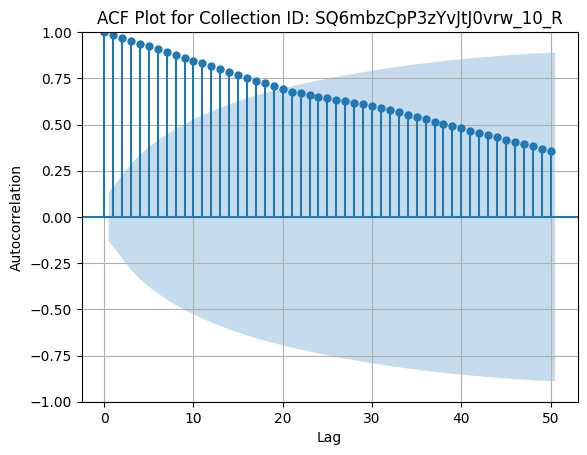

In [15]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# ACF example plot for one random collection id
def plot_acf_example(data):
    random_collection_id = np.random.choice(data['collection_id'].unique(), 1, replace=False)
    phase = data[data['collection_id'] == random_collection_id[0]]['phase']

    plt.figure(figsize=(10, 6))
    plot_acf(phase, lags=50)
    plt.title(f'ACF Plot for Collection ID: {random_collection_id[0]}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.show()

plot_acf_example(scaled_data)

In [16]:
class Lagged_DataSet():
    def __init__(self, data, features, target, lag_size=30):
        self.data = data
        self.features = features
        self.target = target
        self.lag_size = lag_size

        self.X_df = pd.DataFrame()
        self.y_df = pd.DataFrame()
        self.collection_ids_df = pd.DataFrame()

        self.X = pd.DataFrame()
        self.y = pd.DataFrame()
        self.collection_ids = []

        self.make_dataset()

    def make_dataset(self):
        X_df = pd.DataFrame()
        y_df = pd.DataFrame()
        collection_ids_df = pd.DataFrame()
        lagged_feature_names = []

        len_features = len(self.features)

        for collection_id in self.data['collection_id'].unique()[:30]:
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + self.target + ['collection_id']]
            collection_length = len(collection_data)

            if collection_length > self.lag_size:
                lagged_features = {}
                for j in range(len_features):
                    for i in range(1, self.lag_size):
                        lagged_features[f'{self.features[j]}_lag{i}'] = collection_data[self.features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features)
                lagged_feature_names = list(lagged_df.columns)
                collection_data = pd.concat([collection_data, lagged_df], axis=1)

            collection_data.dropna(inplace=True)
            collection_data['collection_id'] = collection_id

            collection_data = collection_data.drop(columns=self.features) # leave only the lagged features
            collection_data = collection_data.dropna(axis=1, how='any') # drop non values

            X_df = pd.concat([X_df, collection_data.drop(columns=self.target + ['collection_id'])], ignore_index=True)
            y_df = pd.concat([y_df, collection_data[self.target]], ignore_index=True)
            collection_ids_df = pd.concat([collection_ids_df, collection_data.drop(columns=self.target + lagged_feature_names)], ignore_index=True)

        self.X_df = X_df.copy().reset_index(drop=True)
        self.y_df = y_df.copy().reset_index(drop=True)
        self.collection_ids_df = collection_ids_df.copy().reset_index(drop=True)

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values

    def __len__(self):
        return len(self.X)


    # returns data that corresponds to first idx collection ids
    def __getitem__(self, idx):
      if isinstance(idx, slice):
        target_ids = self.collection_ids_df['collection_id'].unique()[idx]
        target_ids_idx = self.collection_ids_df.index[self.collection_ids_df['collection_id'].isin(target_ids)].tolist()
        self.X_df = self.X_df.iloc[target_ids_idx]
        self.y_df = self.y_df.iloc[target_ids_idx]
        self.collection_ids_df = self.collection_ids_df.iloc[target_ids_idx]

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values

        return self
      else:
        target_ids = self.collection_ids_df['collection_id'].unique()[idx]
        target_ids_idx = self.collection_ids_df.index[self.collection_ids_df['collection_id'].isin(target_ids)].tolist()
        self.X_df = self.X_df.iloc[target_ids_idx]
        self.y_df = self.y_df.iloc[target_ids_idx]
        self.collection_ids_df = self.collection_ids_df.iloc[target_ids_idx]

        self.X = self.X_df.values
        self.y = self.y_df.values
        self.collection_ids = self.collection_ids_df.values

        return self

features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = ['phase']
dataset = Lagged_DataSet(scaled_data, features, target, lag_size)

In [17]:
np.unique(dataset.y) # phases

array([0, 1, 2, 3])

In [18]:
dataset.collection_ids_df['collection_id']

0       vh92aaJeQLxDazem2hN5_6_L
1       vh92aaJeQLxDazem2hN5_6_L
2       vh92aaJeQLxDazem2hN5_6_L
3       vh92aaJeQLxDazem2hN5_6_L
4       vh92aaJeQLxDazem2hN5_6_L
                  ...           
6168    fvvvFT3GKhO0m29w5B3M_8_L
6169    fvvvFT3GKhO0m29w5B3M_8_L
6170    fvvvFT3GKhO0m29w5B3M_8_L
6171    fvvvFT3GKhO0m29w5B3M_8_L
6172    fvvvFT3GKhO0m29w5B3M_8_L
Name: collection_id, Length: 6173, dtype: object

fold_1 | train_accuracy: 0.93, val_accuracy: 0.90, train_log_loss: 0.16, val_log_loss: 0.23
fold_2 | train_accuracy: 0.94, val_accuracy: 0.91, train_log_loss: 0.16, val_log_loss: 0.22
fold_3 | train_accuracy: 0.94, val_accuracy: 0.91, train_log_loss: 0.16, val_log_loss: 0.23
fold_4 | train_accuracy: 0.94, val_accuracy: 0.90, train_log_loss: 0.16, val_log_loss: 0.23
fold_5 | train_accuracy: 0.93, val_accuracy: 0.91, train_log_loss: 0.16, val_log_loss: 0.22
mean_train_accuracy: 0.94, mean_train_loss: 0.16
mean_val_accuracy: 0.91, mean_val_loss: 0.23


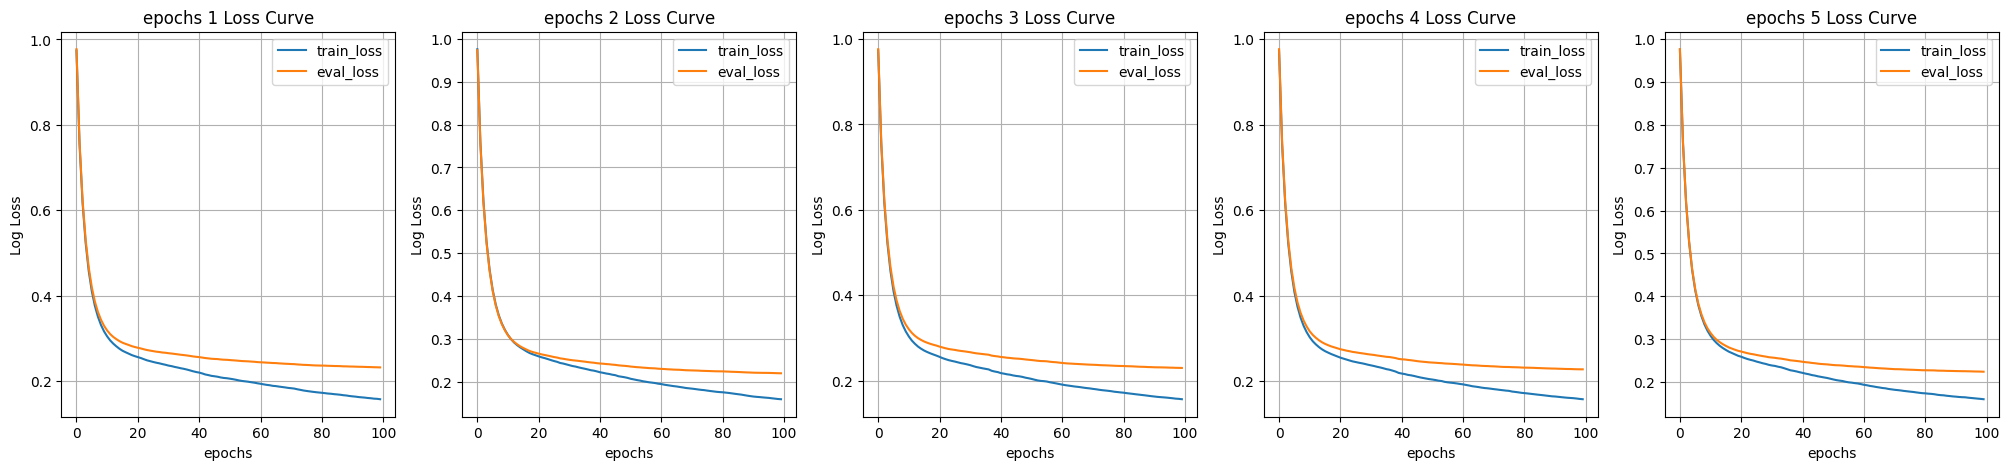

In [ ]:
# ##### model without hyperparameter tuning

# # Test run 용.
# # XGboost 설명
# # XGBoost 파라미터 설명
# # sample_weights 파라미터 설명 ( final report에서는 빼기 )
# # groupKFold 설명
# # GroupShuffleSplit 설명

# from xgboost import XGBClassifier
# from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split, GroupShuffleSplit
# import numpy as np
# import cupy as cp
# from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report
# from sklearn.utils import class_weight
# import matplotlib.pyplot as plt


# def get_train_test_idx(dataset):
#     groups = dataset.collection_ids_df['collection_id']
#     gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
#     train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))
#     return train_idx, test_idx

# def train_XGBoost(dataset, xgb_params, n_splits = 5):
#     groups = dataset.collection_ids_df['collection_id']
#     gkf = GroupKFold(n_splits=n_splits)
#     xgb_clf = XGBClassifier(**xgb_params)

#     train_idx, _ = get_train_test_idx(dataset)
#     X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], groups[train_idx]

#     if cp.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array
#         X_train = cp.asarray(X_train)

#     train_accuracy_score_list =[]
#     eval_accuracy_score_list = []
#     train_loss_score_list = []
#     eval_loss_score_list = []

#     fold_train_loss_value_list = []
#     fold_eval_loss_value_list = []

#     for i, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, train_groups)):
#         X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
#         y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
#         eval_set =[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]

#         train_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold.ravel())
#         train_sample_weights = np.array([train_class_weights[int(phase)] for phase in y_train_fold.ravel()])

#         xgb_clf.fit(X_train_fold,
#                     y_train_fold,
#                     eval_set=eval_set,
#                     sample_weight=train_sample_weights,
#                     verbose=False,
#                     )
#         fold_result = xgb_clf.evals_result()

#         train_accuracy = accuracy_score(y_train_fold, xgb_clf.predict(X_train_fold))
#         val_accuracy = accuracy_score(y_val_fold, xgb_clf.predict(X_val_fold))
#         train_log_loss = log_loss(y_train_fold, xgb_clf.predict_proba(X_train_fold))
#         val_log_loss = log_loss(y_val_fold, xgb_clf.predict_proba(X_val_fold))

#         print(f'fold_{i+1} | train_accuracy: {train_accuracy:.2f}, val_accuracy: {val_accuracy:.2f}, train_log_loss: {train_log_loss:.2f}, val_log_loss: {val_log_loss:.2f}')

#         train_accuracy_score_list.append(train_accuracy)
#         eval_accuracy_score_list.append(val_accuracy)
#         train_loss_score_list.append(train_log_loss)
#         eval_loss_score_list.append(val_log_loss)

#         # Store loss curves for this fold
#         fold_train_loss_value_list.append(fold_result['validation_0']['mlogloss'])
#         fold_eval_loss_value_list.append(fold_result['validation_1']['mlogloss'])

#     print(f'mean_train_accuracy: {np.mean(train_accuracy_score_list):.2f}, mean_train_loss: {np.mean(train_loss_score_list):.2f}')
#     print(f'mean_val_accuracy: {np.mean(eval_accuracy_score_list):.2f}, mean_val_loss: {np.mean(eval_loss_score_list):.2f}')

#     # [TODO] Fold 후 train_loss, eval_loss plot 한 행에 그리기
#     plt.figure(figsize=(n_splits * 5, 5))
#     for i in range(n_splits):
#       plt.subplot(1, n_splits, i+1)
#       epochs = range(len(fold_train_loss_value_list[i]))
#       plt.plot(epochs, fold_train_loss_value_list[i], label='train_loss')
#       plt.plot(epochs, fold_eval_loss_value_list[i], label='eval_loss')
#       plt.title(f'epochs {i+1} Loss Curve')
#       plt.xlabel('epochs')
#       plt.ylabel('Log Loss')
#       plt.legend()
#       plt.grid(True)
#     plt.show()


#     return xgb_clf

# xgb_params={
#     'objective': 'multi:softmax',
#     'eval_metric': 'mlogloss',
#     'num_class': len(np.unique(dataset.y)),
#     'seed': 42,
#     # 'early_stopping_rounds': 10  # Check loss curve to decide early stopping rounds
# }

# if cp.cuda.runtime.getDeviceCount() > 0:
#   xgb_params['tree_method'] = 'hist'
#   xgb_params['device']= 'cuda'

# naive_model = train_XGBoost(dataset, xgb_params)


In [ ]:
# for k, v in model.get_params().items():
#     print(f'{k}: {v}')

In [ ]:
# def testXGBoost(dataset, model):
#     _, test_idx = get_train_test_idx(dataset)
#     X_test, y_test = dataset.X[test_idx], dataset.y[test_idx]

#     y_pred = model.predict(X_test)
#     print(f'test accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}')

#     labels = range(len(np.unique(y_test)))
#     class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
#     print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))

# testXGBoost(dataset, naive_model)

In [ ]:
# #### Grid Search without Early Stopping
# # Final report 추가
# # XGboost 설명
# # XGBoost 파라미터 설명
# # sample_weights 파라미터 설명 ( final report에서는 빼기 )
# # groupKFold 설명
# # GroupShuffleSplit 설명

# from xgboost import XGBClassifier
# from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split, GroupShuffleSplit
# import numpy as np
# from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report
# import matplotlib.pyplot as plt
# import cupy as cp

# def get_train_test_idx(dataset):
#     groups = dataset.collection_ids_df['collection_id']
#     gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=0)
#     train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))

#     return train_idx, test_idx

# def train_XGBoost_grid_search(dataset, xgb_param_grid):
#     groups = dataset.collection_ids_df['collection_id']
#     gkf = GroupKFold(n_splits=5)
#     xgb_clf = XGBClassifier()

#     train_idx, _ = get_train_test_idx(dataset)
#     X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], groups[train_idx]

#     if cp.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array
#       X_train = cp.asarray(X_train)

#     # train_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.ravel())
#     # train_sample_weights = np.array([train_class_weights[int(phase)] for phase in y_train.ravel()])

#     xgb_grid = GridSearchCV(
#         xgb_clf,
#         param_grid=xgb_param_grid,
#         cv=gkf,
#         scoring='accuracy',
#         n_jobs=1,
#         verbose=10
#     )

#     grid_result = xgb_grid.fit(
#         X_train,
#         y_train,
#         groups=train_groups,
#         verbose=0
#     )

#     print(f'best score:{grid_result.best_score_}')
#     print(f'best param:{grid_result.best_params_}')

#     model = grid_result.best_estimator_
#     return model

# xgb_param_grid = {
#     'n_estimators': [100, 300, 500, 700, 900], # dafault : 100
#     'learning_rate': [0.05, 0.1, 0.5],  # default : 0.1
#     'max_depth': [4, 6, 8], # default : 6
#     'reg_alpha': [0, 0.1, 0.5], # default : 0
#     'reg_lambda': [0.1, 0.5, 1.0], # default : 1
#     'objective': ['multi:softmax'],
#     'eval_metric': ['mlogloss'],
#     'seed': [42],
#     'num_class': [len(np.unique(dataset.y))],
# }

# if cp.cuda.runtime.getDeviceCount() > 0:
#   xgb_param_grid['tree_method'] = ['hist']
#   xgb_param_grid['device']= ['cuda']

# grid_model = train_XGBoost_grid_search(dataset, xgb_param_grid)

In [ ]:
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report

# def test_XGBoost_grid_result(dataset, model):
#     _, test_idx = get_train_test_idx(dataset)
#     X_test, y_test = dataset.X[test_idx], dataset.y[test_idx]

#     y_pred = model.predict(X_test)
#     print(f'test accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}')

#     labels = range(len(np.unique(y_test)))
#     class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
#     print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))

# test_XGBoost_grid_result(dataset, grid_model)

In [ ]:
# n_collection_ids = len(np.unique(dataset.collection_ids))
# n_collection_ids

2324

In [ ]:
# n_collection_ids//5

464

In [170]:
#### Grid Search with Early Stopping
# # Final report 추가
# # XGboost 설명
# # XGBoost 파라미터 설명
# # sample_weights 파라미터 설명 ( final report에서는 빼기 )
# # groupKFold 설명 -> 하나의 그룹은 테스트 인덱스, 나머지 그룹은
# # GroupShuffleSplit 설명 ->

# Manual로 실행한 이유 -> early stopping / sample weight을 사이킷런 grid search 모듈을 사용할 경우 설정이 어려움
'''
  [TODO] Implementing Grid Search Manually

  https://xgboosting.com/xgboost-early-stopping-with-grid-search/
  https://gist.github.com/sandys/d0acf13976bae81df253d0a09436cb2b
'''
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split, GroupShuffleSplit
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, classification_report
import matplotlib.pyplot as plt
import numpy as np
# import cupy as cp
import itertools
import time

def get_train_test_idx(dataset):
    groups = dataset.collection_ids['collection_ids']
    gs = GroupShuffleSplit(n_splits=2, test_size=.2, random_state=42) # 동일한 그룹에 속한 데이터는 훈련 세트와 테스트 세트에 중복되지 않도록 보장
    train_idx, test_idx = next(gs.split(dataset.X, dataset.y, groups=groups))
    # print(f'train/test dataset by groups is split correctly: {not any(item in dataset.collection_ids[test_idx] for item in dataset.collection_ids[train_idx])}')

    return train_idx, test_idx


def train_XGBoost_manual_grid_search(dataset, xgb_param_grid):
    # n_collection_dis = len(np.unique(dataset.collection_ids))

    # early stopping
    # early_stopping_rounds = 15

    # train dataset
    train_idx, _ = get_train_test_idx(dataset)
    groups = dataset.collection_ids_df['collection_id']
    X_train, y_train, train_groups = dataset.X[train_idx], dataset.y[train_idx], groups[train_idx]

    # if cp.cuda.runtime.getDeviceCount() > 0: # if gpu available, convert numpy array to cupy array
    #     X_train = cp.asarray(X_train)

    n_splits = 10 # if the split too bit, for example 1800, toe off might not be included in the test set
    gkf = GroupKFold(n_splits=n_splits)
    xgb_clf = XGBClassifier()

    # calculate the total rounds
    param_values = list(xgb_param_grid.values())
    all_combinations = list(itertools.product(*param_values))
    total_combinations = len(all_combinations)
    total_round = total_combinations * n_splits
    current_round = 1
    print(f'total round: {total_round}')

    # best score
    best_score = 0
    best_params = {}
    best_eval_result = None
    best_model = None

    for n_estimators in xgb_param_grid['n_estimators']:
        for learning_rate in xgb_param_grid['learning_rate']:
            for max_depth in xgb_param_grid['max_depth']:
                for reg_alpha in xgb_param_grid['reg_alpha']:
                    for reg_lambda in xgb_param_grid['reg_lambda']:
                      for gamma in xgb_param_grid['gammar']:
                        print(f'current params: n_estimators:{n_estimators:}, learning_rate:{learning_rate}, max_depth:{max_depth}, reg_alpha:{reg_alpha}, reg_lambda:{reg_lambda}, gamma:{gamma}') #, early_stopping_rounds:{early_stopping_rounds}')

                        # store result values per fold
                        train_log_loss_list = []
                        val_accuracy_list = []
                        val_log_loss_list = []

                        # values for loss_curve
                        fold_train_loss_value_list = []
                        fold_eval_loss_value_list = []
                        avg_fold_loss_list = []

                        for i, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, train_groups)):
                            start_time = time.perf_counter()

                            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
                            eval_set = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]

                            # give more weight to the minor class
                            # train_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_fold), y=y_train_fold.ravel())
                            # train_sample_weights = np.array([train_class_weights[int(phase)] for phase in y_train_fold.ravel()])

                            xgb_clf.set_params(
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                #early_stopping_rounds = early_stopping_rounds,
                                objective=xgb_param_grid['objective'][0],
                                eval_metric=xgb_param_grid['eval_metric'][0],
                                seed=xgb_param_grid['seed'][0],
                                num_class=xgb_param_grid['num_class'][0],
                            )

                            xgb_clf.fit(
                                X_train_fold,
                                y_train_fold,
                                eval_set=eval_set,
                                # sample_weight=train_sample_weights,
                                verbose=False
                            )

                            fold_result = xgb_clf.evals_result()

                            val_accuracy = accuracy_score(y_val_fold, xgb_clf.predict(X_val_fold))
                            train_log_loss = log_loss(y_train_fold, xgb_clf.predict_proba(X_train_fold))
                            val_log_loss = log_loss(y_val_fold, xgb_clf.predict_proba(X_val_fold))

                            val_accuracy_list.append(val_accuracy)
                            train_log_loss_list.append(train_log_loss)
                            val_log_loss_list.append(val_log_loss)

                            fold_train_loss_value_list.append(fold_result['validation_0']['mlogloss']) # training loss values
                            fold_eval_loss_value_list.append(fold_result['validation_1']['mlogloss']) # eval loss values

                            end_time = time.perf_counter()

                            print(f'{current_round}/{total_round} | Fold:{i+1}/{n_splits} | val_accuracy: {val_accuracy:.6f} | train_log_loss: {train_log_loss:.6f}, val_log_loss: {val_log_loss:.6f}, time: {(end_time - start_time):.4f}')
                            print(f'train groups : {np.unique(dataset[train_index][2])}')
                            print(f'val groups : {np.unique(dataset[val_index][2])}')

                            current_round += 1

                        avg_fold_loss_list = {'validation_0': [sum(values) / len(values) for values in zip(*fold_train_loss_value_list)],
                                              'validation_1': [sum(values) / len(values) for values in zip(*fold_eval_loss_value_list)]}

                        # Compute average score across all folds
                        average_val_accuracy = np.mean(val_accuracy_list)
                        print(f'avg_val_accuracy: {average_val_accuracy:.6f} | avg_train_loss: {np.mean(train_log_loss_list):.6f}, avg_val_loss: {np.mean(val_log_loss_list):.6f}')
                        if average_val_accuracy > best_score:
                            best_score = average_val_accuracy
                            best_params = {
                                'n_estimators': n_estimators,
                                'learning_rate': learning_rate,
                                'max_depth': max_depth,
                                'reg_alpha': reg_alpha,
                                'reg_lambda': reg_lambda,
                                'objective': xgb_param_grid['objective'],
                                'eval_metric': xgb_param_grid['eval_metric'],
                                'seed': xgb_param_grid['seed'],
                                'num_class': xgb_param_grid['num_class'],
                                # 'early_stopping_rounds': early_stopping_rounds
                            }
                            best_eval_result = avg_fold_loss_list
                            best_model = xgb_clf


    print(f'Best Accuracy:{best_score:.6f}')
    print(f'Best Params:\n {best_params}')
    return best_model, best_params, best_eval_result, avg_fold_loss_list, avg_fold_loss_list

xgb_param_manual_grid = {
    'n_estimators': [100, 300, 500, 700], # dafault : 100
    'learning_rate': [0.05 , 0.1, 0.5],  # default : 0.1
    'max_depth': [4, 6, 8, 10], # default : 6
    'reg_alpha': [0, 0.1, 0.5], # default : 0
    'reg_lambda': [0.1, 0.5, 1.0], # default : 1
    'objective': ['multi:softmax'],
    'gammar': [1,3,5],
    'eval_metric': ['mlogloss'],
    'seed': [42],
    'num_class': [len(np.unique(dataset.y))],
}

# if cp.cuda.runtime.getDeviceCount() > 0:
#     xgb_param_manual_grid['tree_method'] = ['hist']
#     xgb_param_manual_grid['device'] = ['cuda']
#     print('training running on cuda')

small_dataset = dataset[:100]
manual_grid_model, best_params, best_eval_result = train_XGBoost_manual_grid_search(small_dataset, xgb_param_manual_grid)


training running on cuda


KeyError: "None of [Index(['gyroscope_x_lag1', 'gyroscope_x_lag2', 'gyroscope_x_lag3',\n       'gyroscope_x_lag4', 'gyroscope_x_lag5', 'gyroscope_x_lag6',\n       'gyroscope_x_lag7', 'gyroscope_x_lag8', 'gyroscope_x_lag9',\n       'gyroscope_x_lag10',\n       ...\n       'accelerometer_z_lag9', 'accelerometer_z_lag10',\n       'accelerometer_z_lag11', 'accelerometer_z_lag12',\n       'accelerometer_z_lag13', 'accelerometer_z_lag14',\n       'accelerometer_z_lag15', 'accelerometer_z_lag16',\n       'accelerometer_z_lag17', 'accelerometer_z_lag18'],\n      dtype='object', length=108)] are in the [columns]"

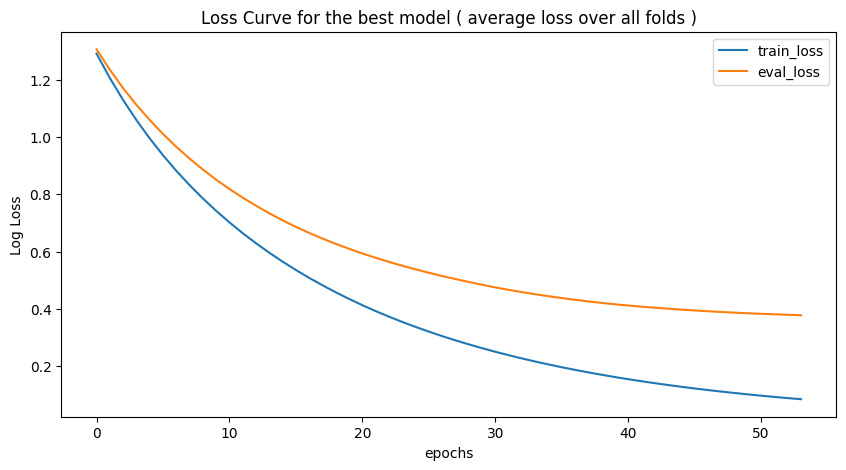

In [76]:
import matplotlib.pyplot as plt

# 가정: best_eval_result['validation_0']와 best_eval_result['validation_1']는 리스트나 배열입니다.
# epochs는 데이터의 길이를 기준으로 생성
epochs = range(len(best_eval_result['validation_0']))

plt.figure(figsize=(10, 5))
plt.plot(epochs, best_eval_result['validation_0'], label='train_loss')  # x: epochs, y: train_loss
plt.plot(epochs, best_eval_result['validation_1'], label='eval_loss')  # x: epochs, y: eval_loss
plt.title('Loss Curve for the best model ( average loss over all folds )')
plt.xlabel('epochs')
plt.ylabel('Log Loss')
plt.legend()  # 범례 추가
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def test_XGBoost_grid_result(dataset, model):
    _, test_idx = get_train_test_idx(dataset)
    X_test, y_test, test_groups = dataset.X[test_idx], dataset.y[test_idx], dataset.collection_ids[test_idx]
    print(f'test on {len(np.unique(test_groups))} collection ids:{np.unique(test_groups)}')

    y_pred = model.predict(X_test)
    print(f'test accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}')

    labels = range(len(np.unique(y_test)))
    class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
    print(classification_report(y_test, y_pred, labels=labels, target_names=class_names))

test_XGBoost_grid_result(dataset, manual_grid_model)

test on 465 collection ids:[  18   23   25   29   44   48   49   51   56   65   67   69   70   73
   76   84   96   99  100  109  111  120  124  128  134  135  157  163
  168  173  174  177  178  179  184  185  188  192  196  203  208  211
  212  218  219  229  230  231  233  239  240  247  251  252  254  259
  275  279  281  282  283  286  289  290  296  297  298  303  307  321
  324  332  342  350  353  354  361  366  367  368  374  383  387  402
  406  408  410  414  416  420  422  423  426  430  432  433  435  438
  440  445  450  457  461  463  464  471  472  478  479  480  482  485
  486  495  507  509  522  529  530  532  544  548  554  555  564  575
  581  582  596  598  599  602  605  611  613  617  629  630  637  642
  643  647  649  670  672  678  679  685  686  693  694  695  707  719
  727  733  736  742  744  748  755  756  764  765  785  786  787  788
  792  800  817  821  829  834  838  840  845  857  862  869  873  874
  879  888  889  891  892  893  906  915  927  929

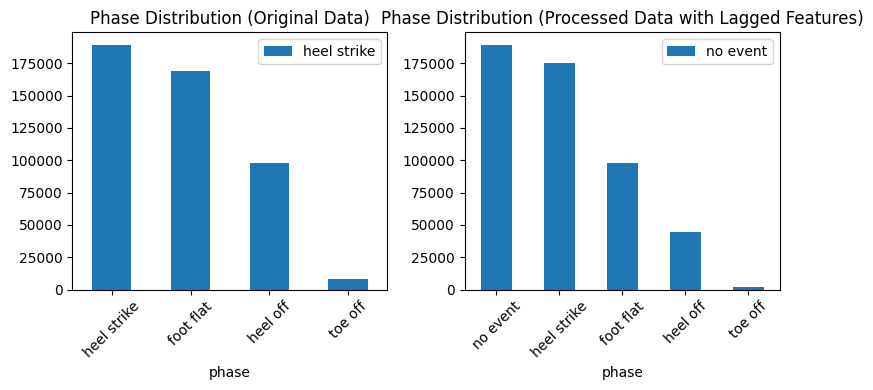

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figsize for smaller plots

original_class_names = ['heel strike', 'foot flat', 'heel off', 'toe off']
# Plot dataset Y distribution
dataset.y_df.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_xticks(range(len(original_class_names)))
axes[0].set_xticklabels(original_class_names, rotation=45)
axes[0].legend(original_class_names)
axes[0].set_title('Phase Distribution (Original Data)')

lagged_class_names = ['no event', 'heel strike', 'foot flat', 'heel off', 'toe off']
# Plot data phase distribution
data['phase'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_xticks(range(len(lagged_class_names)))
axes[1].set_xticklabels(lagged_class_names, rotation=45)
axes[1].legend(lagged_class_names)
axes[1].set_title('Phase Distribution (Processed Data with Lagged Features)')

plt.tight_layout()
plt.show()

# sample_weight를 통해 imbalanced 클래스 극복하려 했으나 안됨 --> 이유?

In [ ]:
'''
주요 차이점
목적
GroupKFold: 모든 그룹을 테스트 세트로 한 번씩 포함시키는 교차 검증 방식입니다.
GroupShuffleSplit: 그룹을 랜덤하게 샘플링하여 훈련 세트와 테스트 세트를 나누는 방식으로, 랜덤 샘플링을 반복하는 것이 목적입니다.
Fold 수 (n_splits)
GroupKFold: Fold 수는 그룹 수보다 작거나 같아야 하며, 고정된 수의 Fold를 생성합니다.
GroupShuffleSplit: Fold 수는 사용자가 반복 횟수를 자유롭게 설정할 수 있습니다.
테스트 세트
GroupKFold: 매 Split에서 고정된 그룹이 테스트 세트로 선택됩니다. 각 그룹은 정확히 한 번씩 테스트 세트로 사용됩니다.
GroupShuffleSplit: 매 Split마다 랜덤하게 선택된 그룹이 테스트 세트로 사용됩니다.
데이터 분할 방식
GroupKFold: 모든 데이터를 사용하며, 그룹 간 교차 검증 방식으로 동작합니다.
GroupShuffleSplit: 랜덤 샘플링 방식으로 데이터를 분할합니다.
유형
GroupKFold: 결정적 방식(Deterministic)으로, 동일한 데이터와 설정에서 항상 같은 결과를 얻습니다.
GroupShuffleSplit: 확률적 방식(Probabilistic)으로, 난수 기반 설정 시 매번 결과가 달라질 수 있습니다.
적합한 경우
GroupKFold: 데이터가 작고, 각 그룹을 테스트 세트로 정확히 한 번씩 평가해야 하는 경우 적합합니다.
GroupShuffleSplit: 대규모 데이터에서 랜덤 검증 반복이 필요하거나 테스트 세트 크기(test_size)를 명시적으로 설정하고 싶은 경우 적합합니다.
'''